Import all the Dependencies

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=8

Import data into tensorflow dataset object

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/tomato',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2840 files belonging to 3 classes.


In [6]:
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
class_names = dataset.class_names
class_names

['Tomato___Early_blight-20220517T133612Z-001',
 'Tomato___Late_blight-20220517T134538Z-001',
 'Tomato___healthy-20220517T141244Z-001']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 1 1 1 1 0 2 1 2 2 1 2 0 0 2 1 2 0 0 1 2 0 0 2 2 2 1 0]


Visualize some of the images from our dataset

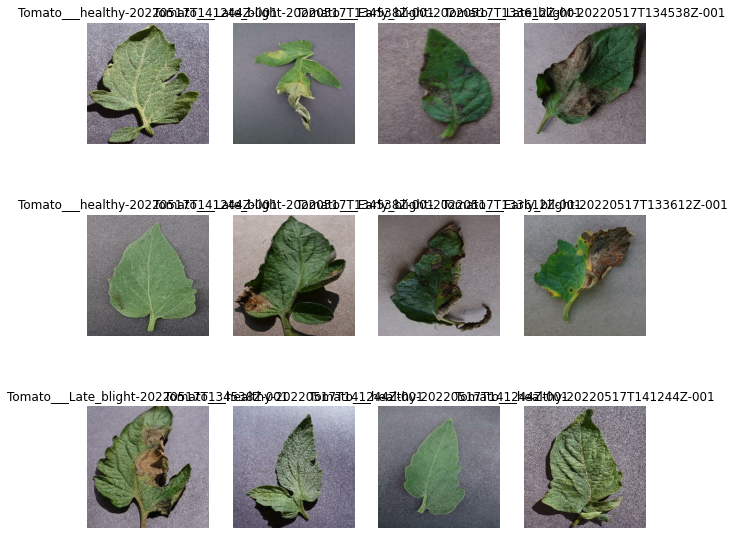

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

89

In [11]:
train_size = 0.8
len(dataset)*train_size

71.2

In [12]:
train_ds = dataset.take(15)
len(train_ds)


15

In [13]:
test_ds = dataset.skip(15)
len(test_ds)

74

In [14]:
val_size=0.1
len(dataset)*val_size

8.9

In [15]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [16]:
test_ds = test_ds.skip(1)
len(test_ds)

73

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

71

In [20]:
len(val_ds)

8

In [21]:
len(test_ds)

10

Cache, Shuffle, and Prefetch the Dataset

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model
Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.



In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=8,
)

Epoch 1/8
71/71 [==============================] - 563s 4s/step - loss: 0.9684 - accuracy: 0.4814 - val_loss: 0.7263 - val_accuracy: 0.6328
Epoch 2/8
71/71 [==============================] - 255s 4s/step - loss: 0.6219 - accuracy: 0.7129 - val_loss: 0.7790 - val_accuracy: 0.7031
Epoch 3/8
71/71 [==============================] - 254s 4s/step - loss: 0.5419 - accuracy: 0.7610 - val_loss: 0.5648 - val_accuracy: 0.8125
Epoch 4/8
71/71 [==============================] - 256s 4s/step - loss: 0.3676 - accuracy: 0.8463 - val_loss: 0.6501 - val_accuracy: 0.7930
Epoch 5/8
71/71 [==============================] - 257s 4s/step - loss: 0.3309 - accuracy: 0.8622 - val_loss: 0.6730 - val_accuracy: 0.7812
Epoch 6/8
71/71 [==============================] - 256s 4s/step - loss: 0.3294 - accuracy: 0.8573 - val_loss: 0.5667 - val_accuracy: 0.8047
Epoch 7/8
71/71 [==============================] - 254s 4s/step - loss: 0.2957 - accuracy: 0.8750 - val_loss: 0.6041 - val_accuracy: 0.8164
Epoch 8/8
71/71 [===

In [30]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 16s 874ms/step - loss: 0.3712 - accuracy: 0.8375


In [31]:
scores

[0.3711606562137604, 0.8374999761581421]

Plotting the Accuracy and Loss Curves

In [32]:
history

In [33]:
history.params

{'epochs': 8, 'steps': 71, 'verbose': 1}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

8

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9683772921562195,
 0.6218559145927429,
 0.5418919324874878,
 0.3676290214061737,
 0.33088168501853943]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [39]:
model.save('content/drive/My Drive/Colab Notebooks/Models/babalHola.h5')

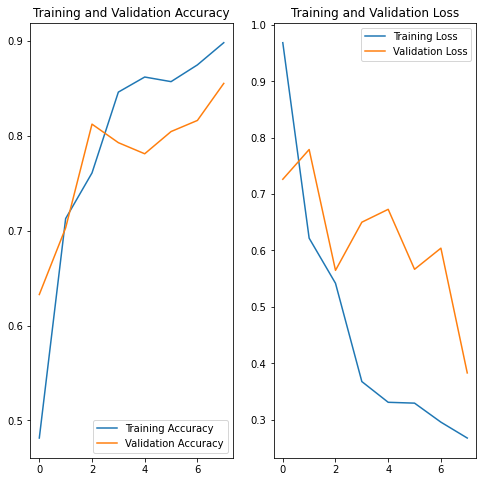

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

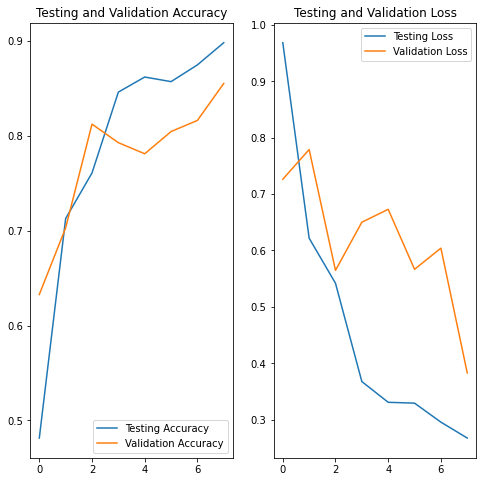

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Testing Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Testing and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Testing Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Testing and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Tomato___healthy-20220517T141244Z-001
predicted label: Tomato___healthy-20220517T141244Z-001


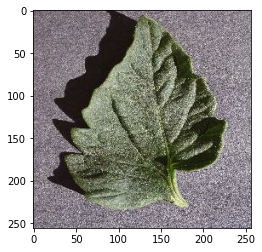

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    plt.imshow(img)
    return predicted_class, confidence

('Tomato___healthy-20220517T141244Z-001', 100.0)

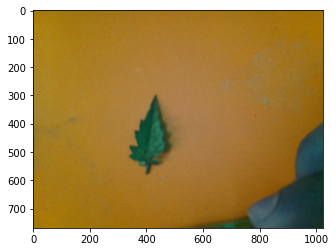

In [65]:
import cv2

z = cv2.imread("/content/drive/MyDrive/raspimg (1)/photo0 (1).jpg")

new_model = tf.keras.models.load_model('/content/content/drive/My Drive/Colab Notebooks/Models/babalHola.h5')

predict(new_model, z)

('Tomato___healthy-20220517T141244Z-001', 100.0)

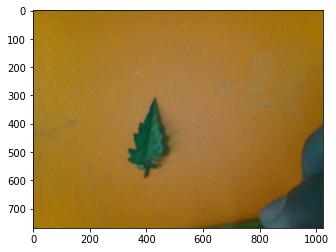

In [66]:
import cv2

z = cv2.imread("/content/drive/MyDrive/raspimg (1)/photo1 (1).jpg")

new_model = tf.keras.models.load_model('content/drive/My Drive/Colab Notebooks/Models/babalHola.h5')

predict(new_model, z)

('Tomato___healthy-20220517T141244Z-001', 100.0)

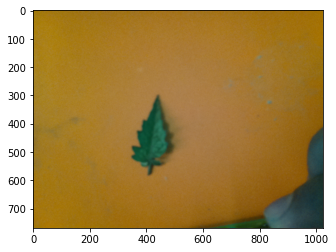

In [67]:
import cv2

z = cv2.imread("/content/drive/MyDrive/raspimg (1)/photo2 (1).jpg")

new_model = tf.keras.models.load_model('/content/content/drive/My Drive/Colab Notebooks/Models/babalHola.h5')

predict(new_model, z)


Now run inference on few sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


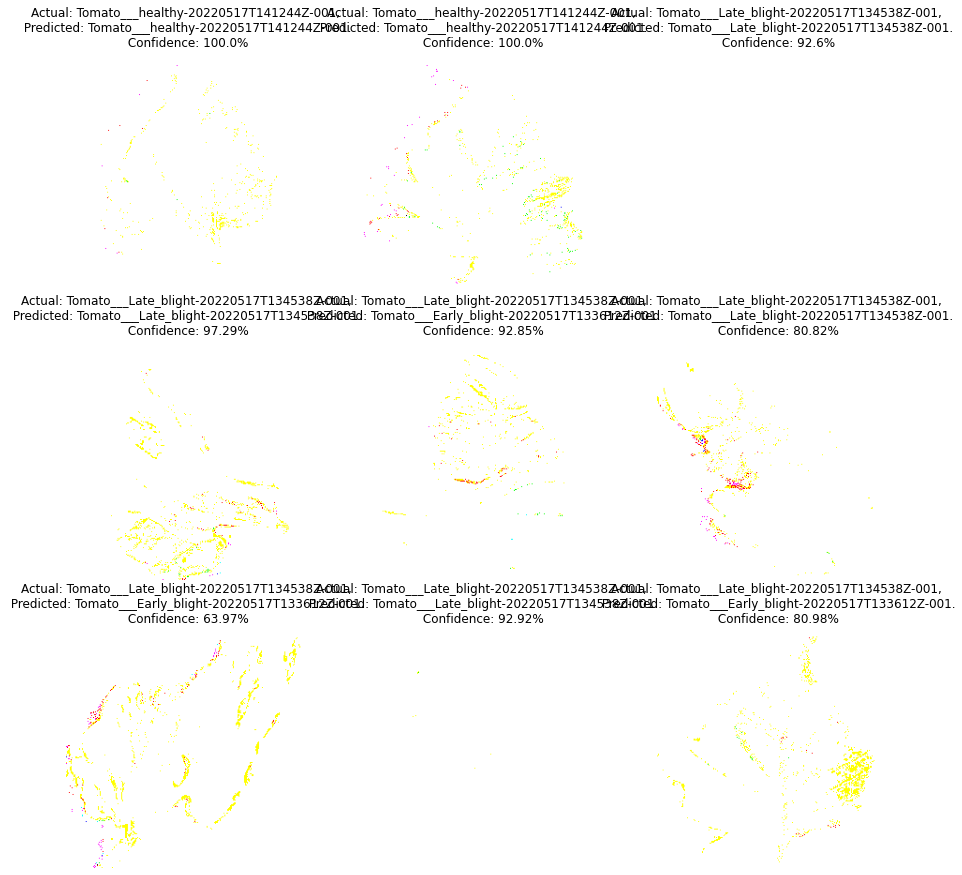

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")